<a href="https://colab.research.google.com/github/thainehassumpcao/Up2Date/blob/master/Up2Date_prototype_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Up2Date prototype**
This prototype showcases the concept proposed by our team (Up2Date) at the Copernicus Barcelona Hackathon.

**Goal:** to improve flood preparedness by updating GloFAS impact forecasts based on satellite images. The Minimum Viable Product is focused on agricultural areas.

Two products are proposed:

*   Product 1: updated affected agricultural areas
*   Product 2: updated impact assessment statistics


### **Prototype details and methodology**

We focus on a flood occuring in September 2020 at the Sindh province in Pakistan, namely updating the forecast done on 01-09-2020.

The steps taken are:

1.   Fetch forecasted data:
    * Flood extent: manifactured to be similar to the flood extent visualized in GloFAS. 
    * Impact assessment: extracted manually from GloFAS html
2.   Search satellite images
3.   





###Setup

In [1]:
!pip install sentinelsat
!pip install rasterio
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import numpy as np
import requests
from zipfile import ZipFile
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup
from getpass import getpass
import folium
import os
import shutil
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt

     |████████████████████████████████| 18.3MB 236kB/s 


In [2]:
def load_git_data():
    """Load a toy flood extent shapefile and the Sindh region shapefile from GitHub"""

    try:
        !git clone -l -s https://github.com/thainehassumpcao/Up2Date cloned-repo
    except:
        print('Repository already cloned')
    
    return

load_git_data()

Cloning into 'cloned-repo'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 42 (delta 13), reused 27 (delta 5), pack-reused 0
Unpacking objects: 100% (42/42), done.


##Fetch forecasted data

In [3]:
# TODO plot map of fe

In [4]:
# Fetch impact assessment 
# string extract from glofas webpage using developer tools
html_string = '<tbody><tr><th scope="row">Estimated protection levels [yr]</th><td class="text-center">0</td></tr><tr><th scope="row">Population affected [No. of people]</th><td class="text-center">325200</td></tr><tr><th scope="row">Artificial surfaces [ha]</th><td class="text-center">1</td></tr><tr><th scope="row">Agricultural surfaces [ha]</th><td class="text-center">914</td></tr><tr><th scope="row">Forest and seminatural [ha]</th><td class="text-center">N/A</td></tr><tr><th scope="row">Estimated peak time [d]</th><td class="text-center">1</td></tr><tr><th scope="row">Estimated mean return period [yr]</th><td class="text-center">12</td></tr><tr><th scope="row">Mean probability of exceeding 2-years threshold</th><td class="text-center">100</td></tr><tr><th scope="row">Mean probability of exceeding 5-years threshold</th><td class="text-center">100</td></tr><tr><th scope="row">Mean probability of exceeding 20-years threshold</th><td class="text-center">24</td></tr></tbody>'

soup = BeautifulSoup(html_string, 'lxml')
table = soup.find_all('tbody')[0]
n_rows = len(table.find_all('th'))
new_table = pd.DataFrame(columns=range(0,2), index = range(0,n_rows))

for row_number, row in enumerate(table.find_all('tr')):
    column_parameter = row.find_all('th')
    column_value = row.find_all('td')
    new_table.iat[row_number, 0] = column_parameter[0].get_text()
    new_table.iat[row_number, 1] = column_value[0].get_text()

new_table

,0,1
0,Estimated protection levels [yr],0
1,Population affected [No. of people],325200
2,Artificial surfaces [ha],1
3,Agricultural surfaces [ha],914
4,Forest and seminatural [ha],N/A
5,Estimated peak time [d],1
6,Estimated mean return period [yr],12
7,Mean probability of exceeding 2-years threshold,100
8,Mean probability of exceeding 5-years threshold,100
9,Mean probability of exceeding 20-years threshold,24


##Search satellite images

In [5]:
# Prepare the API - Require credentials to access the copernicus hub:
user = input('User name: ')
password = getpass('Password: ')
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/apihub')
del user, password

# Query products based on an Area of Interest and date interval
# Very low cloud coverage, we want clean images!
# TODO create rotated bounding box from flood extent file -> depends on input format -> will we get the full world map?
AOI = read_geojson('cloned-repo/toy_mask_for_hazard_map.geojson')
products = api.query(
    area = geojson_to_wkt(AOI),
    date = ('20200810', '20200901'),
    platformname = 'Sentinel-2',
    cloudcoverpercentage=(0,20))

User name: thaineha
Password: ··········


In [6]:
# Inspect results
df = api.to_dataframe(products)
print(len(df.index))
df

8


,title,link,link_alternative,link_icon,summary,ondemand,datatakesensingstart,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,sensoroperationalmode,gmlfootprint,footprint,level1cpdiidentifier,tileid,hv_order_tileid,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,uuid,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage
344b1767-1876-4a23-87b4-3c1d2eb1268a,S2B_MSIL1C_20200826T055639_N0209_R091_T42RVN_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-26T05:56:39.024Z, Instrument: MS...",false,2020-08-26 05:56:39.024,2020-08-26 05:56:39.024,2020-08-26 05:56:39.024,2020-08-26 11:25:21.775,18135,91,13.022800,INS-NOBS,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((68.01399386223481 24.321894111...,S2B_OPER_MSI_L1C_TL_VGS2_20200826T080109_A0181...,42RVN,RN42V,SAFE,02.09,Sentinel-2,S2B_MSIL1C_20200826T055639_N0209_R091_T42RVN_2...,Multi-Spectral Instrument,MSI,781.43 MB,GS2B_20200826T055639_018135_N02.09,S2MSI1C,2017-013A,DESCENDING,Sentinel-2B,Level-1C,S2B_MSIL1C_20200826T055639_N0209_R091_T42RVN_2...,344b1767-1876-4a23-87b4-3c1d2eb1268a,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78c91401-5e9d-402a-8469-f6507ae19f3b,S2A_MSIL1C_20200821T055641_N0209_R091_T42RXP_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-21T05:56:41.024Z, Instrument: MS...",false,2020-08-21 05:56:41.024,2020-08-21 05:56:41.024,2020-08-21 05:56:41.024,2020-08-21 11:56:04.759,26972,91,18.728400,INS-NOBS,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((70.00942709876158 25.224905267...,S2A_OPER_MSI_L1C_TL_VGS1_20200821T074235_A0269...,42RXP,RP42X,SAFE,02.09,Sentinel-2,S2A_MSIL1C_20200821T055641_N0209_R091_T42RXP_2...,Multi-Spectral Instrument,MSI,115.79 MB,GS2A_20200821T055641_026972_N02.09,S2MSI1C,2015-028A,DESCENDING,Sentinel-2A,Level-1C,S2A_MSIL1C_20200821T055641_N0209_R091_T42RXP_2...,78c91401-5e9d-402a-8469-f6507ae19f3b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6570fb41-aa36-4c8e-9649-3a749a9b5298,S2A_MSIL1C_20200818T054641_N0209_R048_T42RWP_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-18T05:46:41.024Z, Instrument: MS...",false,2020-08-18 05:46:41.024,2020-08-18 05:46:41.024,2020-08-18 05:46:41.024,2020-08-18 11:44:17.004,26929,48,17.177800,INS-NOBS,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((70.08984888872256 25.224394540...,S2A_OPER_MSI_L1C_TL_EPAE_20200818T083916_A0269...,42RWP,RP42W,SAFE,02.09,Sentinel-2,S2A_MSIL1C_20200818T054641_N0209_R048_T42RWP_2...,Multi-Spectral Instrument,MSI,346.06 MB,GS2A_20200818T054641_026929_N02.09,S2MSI1C,2015-028A,DESCENDING,Sentinel-2A,Level-1C,S2A_MSIL1C_20200818T054641_N0209_R048_T42RWP_2...,6570fb41-aa36-4c8e-9649-3a749a9b5298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5553608c-2d10-4140-b635-e332b0d4271a,S2B_MSIL2A_20200816T055639_N0214_R091_T42RWP_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-08-16T05:56:39.024Z, Instrument: MS...",false,NaT,2020-08-16 05:56:39.024,2020-08-16 05:56:39.024,2020-08-16 13:23:16.042,17992,91,6.800826,NaN,"<gml:Polygon srsName=""http://www.opengis.net/g...",MULTIPOLYGON (((70.01965672603674 25.224653314...,S2B_OPER_MSI_L1C_TL_VGS1_20200816T074607_A0179...,NaN,NaN,SAFE,02.14,Sentinel-2,S2B_MSIL2A_20200816T055639_N0214_R091_T42RWP_2...,Multi-Spectral Instrument,MSI,1.09 GB,GS2B_20200816T055639_017992_N0

In [7]:
# Map the results
gj = api.to_geojson(products)
m = folium.Map(location=[25.71, 69.175], zoom_start=7)
folium.GeoJson(AOI).add_to(m)
folium.GeoJson(gj).add_to(m)
m

In [8]:
# Download images
def load_sentinel_image(uuid=None, rewrite=False):
    """ Load TCI, B04 and B08 from a single satellite image from copernicus hub
    """

    existing_image = list(Path.cwd().glob('*.tif'))
    if len(existing_image)>0:
        if len(existing_image)>1:
            warning('Multiple images are loaded')

        if rewrite:
            %rm existing_image[0]
        else:
            print('File already exists')
            return

    api.download(uuid)
    
    zip_path = next(Path.cwd().glob('*.zip'))
    with ZipFile(zip_path,'r') as zip_object:
        zip_object.extractall()
    %rm *.zip
    tci_path = next(Path().rglob('*TCI_10m.jp2'))
    b04_path = next(Path().rglob('*B04_10m.jp2'))
    b08_path = next(Path().rglob('*B08_10m.jp2'))
    os.system('cp {} raw_tci.tif'.format(tci_path))
    os.system('cp {} raw_b04.tif'.format(b04_path))
    os.system('cp {} raw_b08.tif'.format(b08_path))
    shutil.rmtree(next(Path.cwd().glob('*.SAFE')))

# Code copied from the table
load_sentinel_image(uuid='b0f31675-c168-4af2-8f30-7a4134d8997e')

Downloading: 100%|██████████| 1.03G/1.03G [04:39<00:00, 3.69MB/s]
MD5 checksumming: 100%|██████████| 1.03G/1.03G [00:02<00:00, 420MB/s]


In [9]:
# Project and mask dataset
!rio warp raw_tci.tif temp.tif --dst-crs EPSG:4326
!rio mask temp.tif crop_tci.tif --overwrite --crop --geojson-mask - < cloned-repo/toy_mask_for_hazard_map.geojson
%rm temp.tif

/usr/local/lib/python3.6/dist-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)
/usr/local/lib/python3.6/dist-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


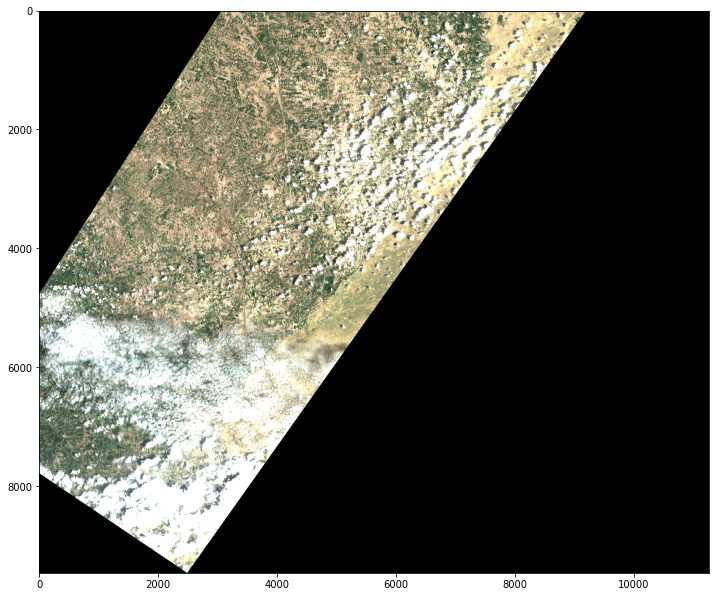

In [10]:
# Display dataset
with rasterio.open('crop_tci.tif', 'r') as dataset:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    img_array = dataset.read()
    show(img_array)

##Assess crop yield

In [11]:
ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)

NameError: ignored

#Re-assess impact

Identify if is a growing season.


## Product 1: Affected agricultural areas

## Product 2: updated impact assessment